<a href="https://colab.research.google.com/github/O-Kpy/Kaggle/blob/main/santander_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import skew

In [24]:
train = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/santander_train.csv')
test = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/santander_test.csv')
submit = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/santander_sample_submission.csv')

In [25]:
data = pd.concat([train, test], axis=0)

In [18]:
data.isnull().sum().sort_values(ascending=False)

target     200000
var_199         0
var_61          0
var_71          0
var_70          0
            ...  
var_129         0
var_128         0
var_127         0
var_126         0
ID_code         0
Length: 202, dtype: int64

In [20]:
data.skew().sort_values(ascending=False)
# 너무 feature가 잘 다듬어져 있는데

target     2.657642
var_168    0.268065
var_2      0.261597
var_179    0.245241
var_163    0.238993
             ...   
var_80    -0.215633
var_86    -0.217701
var_81    -0.233976
var_93    -0.241298
var_44    -0.334506
Length: 201, dtype: float64

# 여기서 더 할 feature engineering은 polynominal 변환, aggregation밖에 없지 않을까?

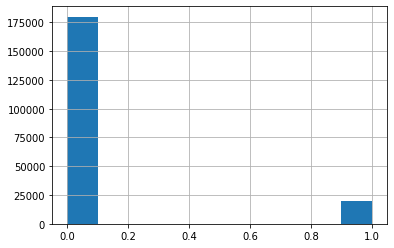

In [23]:
train.target.hist()
# 데이터 불균형이 존재하긴 하네
# 취할 수 있는 액션 ==> 언더샘플링, 오버샘플링(이건 오버피팅 나니까 하지말자)

In [24]:
train

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,2.9252,3.1821,14.0137,0.5745,8.7989,14.5691,5.7487,-7.2393,4.2840,30.7133,10.5350,16.2191,2.5791,2.4716,14.3831,13.4325,-5.1488,-0.4073,4.9306,5.9965,-0.3085,12.9041,-3.8766,16.8911,11.1920,10.5785,0.6764,7.8871,...,15.4576,5.3133,3.6159,5.0384,6.6760,12.6644,2.7004,-0.6975,9.5981,5.4879,-4.7645,-8.4254,20.8773,3.1531,18.5618,7.7423,-10.1245,13.7241,-3.5189,1.7202,-8.4051,9.0164,3.0657,14.3691,25.8398,5.8764,11.8411,-19.7159,17.5743,0.5857,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,-0.4032,8.0585,14.0239,8.4135,5.4345,13.7003,13.8275,-15.5849,7.8000,28.5708,3.4287,2.7407,8.5524,3.3716,6.9779,13.8910,-11.7684,-2.5586,5.0464,0.5481,-9.2987,7.8755,1.2859,19.3710,11.3702,0.7399,2.7995,5.8434,...,29.4846,5.8683,3.8208,15.8348,-5.0121,15.1345,3.2003,9.3192,3.8821,5.7999,5.5378,5.0988,22.0330,5.5134,30.2645,10.4968,-7.2352,16.5721,-7.3477,11.0752,-5.5937,9.4878,-14.9100,9.4245,22.5441,-4.8622,7.6543,-15.9319,13.3175,-0.3566,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,5.9525,-0.3249,-11.2648,14.1929,7.3124,7.5244,14.6472,7.6782,-1.7395,4.7011,20.4775,17.7559,18.1377,1.2145,3.5137,5.6777,13.2177,-7.9940,-2.9029,5.8463,6.1439,-11.1025,12.4858,-2.2871,19.0422,11.0449,4.1087,4.6974,6.9346,...,13.2070,5.8442,4.7086,5.7141,-1.0410,20.5092,3.2790,-5.5952,7.3176,5.7690,-7.0927,-3.9116,7.2569,-5.8234,25.6820,10.9202,-0.3104,8.8438,-9.7009,2.4013,-4.2935,9.3908,-13.2648,3.1545,23.0866,-5.3000,5.3745,-6.2660,10.1934,-0.8417,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,8.2450,2.3061,2.8102,13.8463,11.9704,6.4569,14.8372,10.7430,-0.4299,15.9426,13.7257,20.3010,12.5579,6.8202,2.7229,12.1354,13.7367,0.8135,-0.9059,5.9070,2.8407,-15.2398,10.4407,-2.5731,6.1796,10.6093,-5.9158,8.1723,2.8521,...,31.8833,5.9684,7.2084,3.8899,-11.0882,17.2502,2.5881,-2.7018,0.5641,5.3430,-7.1541,-6.1920,18.2366,11.7134,14.7483,8.1013,11.8771,13.9552,-10.4701,5.6961,-3.7546,8.4117,1.8986,7.2601,-0.4639,-0.0498,7.9336,-12.8279,12.4124,1.8489,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,7.6784,-9.4458,-12.1419,13.8481,7.8895,7.7894,15.0553,8.4871,-3.0680,6.5263,11.3152,21.4246,18.9608,10.1102,2.7142,14.2080,13.5433,3.1736,-3.3423,5.9015,7.9352,-3.1582,9.4668,-0.0083,19.3239,12.4057,0.6329,2.7922,5.8184,...,33.5107,5.6953,5.4663,18.2201,6.5769,21.2607,3.2304,-1.7759,3.1283,5.5518,1.4493,-2.6627,19.8056,2.3705,18.4685,16.3309,-3.3456,13.5261,1.7189,5.1743,-7.6938,9.7685,4.8910,12.2198,11.8503,-7.8931,6.4209,5.9270,16.0201,-0.2829,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,train_199995,0,11.4880,-0.4956,8.2

In [26]:
data_agg = data.drop(columns='target').groupby('ID_code').agg(['mean', 'min', 'max', 'count', 'skew'])
# data를 다 합쳐서 aggregation을 했는데 오버피팅의 위험이 있다.
# 오버피팅 된다면 train, test나눠서 하자

KeyboardInterrupt: ignored

In [ ]:
data_agg_col = []

for i in data_agg.columns.levels[0]:
  for j in data_agg.columns.levels[1]:
    data_agg_col.append(f'{i}-{j}')

data_agg.columns = data_agg_col

In [ ]:
corr_matrix = data_agg.corr()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

to_drop = [c for c in upper.columns if any(abs(upper[c]) > 0.9)]

print(f'There are {len(data_agg.columns)} columns but {len(to_drop)} corr columns to remove')

In [ ]:
data_agg = data_agg.drop(columns=to_drop)
data = data.merge(data_agg, how='left', on='ID_code')

In [5]:
x_train = data.loc[data['target'].notnull()].drop(columns=['ID_code', 'target'])
y_train = data.loc[data['target'].notnull()]['target']
x_test = data.loc[data['target'].isnull()].drop(columns=['ID_code', 'target'])
x_train_col = x_train.columns

In [6]:
from sklearn.preprocessing import MinMaxScaler

x_train = MinMaxScaler().fit_transform(x_train)
x_test = MinMaxScaler().fit_transform(x_test)

In [7]:
x_train = pd.DataFrame(x_train, columns=x_train_col)
x_test = pd.DataFrame(x_test, columns=x_train_col)

In [8]:
pip install catboost

In [9]:
import catboost
import lightgbm
import xgboost
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.model_selection import cross_validate, KFold, StratifiedKFold

In [17]:
auc={}
kf = KFold(n_splits=7, shuffle=True, random_state=42)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for i, (train_index, valid_index) in enumerate(skf.split(x_train, y_train)):
  X_train, X_valid = x_train.iloc[train_index], x_train.iloc[valid_index]
  Y_train, Y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]

  model = lightgbm.LGBMClassifier(n_estimators=3000, learning_rate=0.022, objective='cross_entropy', boosting_type='goss')
  model.fit(X_train, Y_train, eval_set=[(X_train, Y_train), (X_valid, Y_valid)], verbose=100, early_stopping_rounds=70, eval_metric='auc')
  preds_model = model.predict_proba(x_test)[:,1]
  preds_model_valid = model.predict_proba(X_valid)[:,1]
  auc[i] = roc_auc_score(Y_valid, preds_model_valid)
  print(f'{i}번째 AUC값:{auc[i]}')
print(f'mean AUC값:{auc.values}')

Training until validation scores don't improve for 70 rounds.
[100]	training's auc: 0.855867	training's xentropy: 0.27317	valid_1's auc: 0.818172	valid_1's xentropy: 0.282369
[200]	training's auc: 0.893564	training's xentropy: 0.24532	valid_1's auc: 0.848965	valid_1's xentropy: 0.261498
[300]	training's auc: 0.9137	training's xentropy: 0.226001	valid_1's auc: 0.864251	valid_1's xentropy: 0.248305
[400]	training's auc: 0.927175	training's xentropy: 0.211138	valid_1's auc: 0.873093	valid_1's xentropy: 0.239092
[500]	training's auc: 0.936748	training's xentropy: 0.199091	valid_1's auc: 0.879585	valid_1's xentropy: 0.23199
[600]	training's auc: 0.944212	training's xentropy: 0.188921	valid_1's auc: 0.883481	valid_1's xentropy: 0.226708
[700]	training's auc: 0.950524	training's xentropy: 0.180108	valid_1's auc: 0.886592	valid_1's xentropy: 0.222487
[800]	training's auc: 0.955881	training's xentropy: 0.172262	valid_1's auc: 0.888974	valid_1's xentropy: 0.219075
[900]	training's auc: 0.960377	

In [27]:
def model(model, n_splits):
  auc={}
  kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
  for i, (train_index, valid_index) in enumerate(kf.split(x_train, y_train)):
    X_train, X_valid = x_train.iloc[train_index], x_train.iloc[valid_index]
    Y_train, Y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]

    model = model
    model.fit(X_train, Y_train, eval_set=[(X_train, Y_train), (X_valid, Y_valid)], verbose=100, early_stopping_rounds=70, eval_metric='auc')
    preds_model = model.predict(x_test)[:,1]
    preds_model_valid = model.predict_proba(X_valid)[:,1]
    auc[i] = roc_auc_score(Y_valid, preds_model_valid)
    print(f'{i}번째 AUC값:{auc[i]}')
  print(f'mean AUC값:{auc.values}')

In [1]:
model(lightgbm.LGBMRegressor(n_estimators=3000, learning_rate=0.05, objective='auc'), 7)

NameError: ignored

In [20]:
submit['target'] = preds_model
submit

,ID_code,target
0,test_0,0.233199
1,test_1,0.197793
2,test_2,0.317558
3,test_3,0.169651
4,test_4,0.093081
...,...,...
199995,test_199995,0.027904
199996,test_199996,0.005811
199997,test_199997,0.003665
199998,test_199998,0.046145


In [22]:
submit.to_csv('/content/drive/MyDrive/dataset/kaggle/submit_1.csv', index=False)